In [1]:
# MODEL 1: ENHANCED CNN WITH CLASS-SPECIFIC AUGMENTATION
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
df = pd.read_csv("urgent_care_images_master_final.csv")

In [2]:
# Stratified split (same as before)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (6084, 2)
Val: (1304, 2)
Test: (1304, 2)


In [3]:
# Define unified class order
all_classes = sorted(df['label'].unique())
print("All classes:", all_classes)



All classes: ['burn_1and2', 'burn_3rd', 'wound_abrasions', 'wound_bruises', 'wound_diabetic_wounds', 'wound_laceration', 'wound_pressure_wounds', 'wound_venous_wounds']


In [4]:
#  Analyze class distribution
print("Class distribution in training set:")
class_counts = train_df['label'].value_counts()
print(class_counts)

Class distribution in training set:
label
burn_1and2               3413
burn_3rd                  902
wound_pressure_wounds     421
wound_venous_wounds       346
wound_diabetic_wounds     324
wound_bruises             255
wound_laceration          249
wound_abrasions           174
Name: count, dtype: int64


In [5]:

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Create proper mapping for Keras 
class_to_index = {class_name: idx for idx, class_name in enumerate(all_classes)}
print("Class to index mapping:", class_to_index)

# Convert class weights to use numeric indices 
class_weight_dict = {}
for i, class_name in enumerate(all_classes):
    # Find the weight for this class name
    weight_idx = np.where(np.unique(train_df['label']) == class_name)[0][0]
    class_weight_dict[i] = class_weights[weight_idx]

print("\nClass weights (fixed for Keras):")
for idx, weight in class_weight_dict.items():
    print(f"Class {idx} ({all_classes[idx]}): {weight:.2f}")


Class to index mapping: {'burn_1and2': 0, 'burn_3rd': 1, 'wound_abrasions': 2, 'wound_bruises': 3, 'wound_diabetic_wounds': 4, 'wound_laceration': 5, 'wound_pressure_wounds': 6, 'wound_venous_wounds': 7}

Class weights (fixed for Keras):
Class 0 (burn_1and2): 0.22
Class 1 (burn_3rd): 0.84
Class 2 (wound_abrasions): 4.37
Class 3 (wound_bruises): 2.98
Class 4 (wound_diabetic_wounds): 2.35
Class 5 (wound_laceration): 3.05
Class 6 (wound_pressure_wounds): 1.81
Class 7 (wound_venous_wounds): 2.20


In [6]:
#  Set up constants and identify minority/majority classes
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define majority/minority for class-specific augmentation
majority_threshold = class_counts.mean()
minority_classes = class_counts[class_counts < majority_threshold].index
majority_classes = class_counts[class_counts >= majority_threshold].index

print(f"Majority threshold: {majority_threshold:.0f} samples")
print(f"Minority classes: {list(minority_classes)}")
print(f"Majority classes: {list(majority_classes)}")

Majority threshold: 760 samples
Minority classes: ['wound_pressure_wounds', 'wound_venous_wounds', 'wound_diabetic_wounds', 'wound_bruises', 'wound_laceration', 'wound_abrasions']
Majority classes: ['burn_1and2', 'burn_3rd']


In [7]:
# Split data by class frequency
minority_df = train_df[train_df['label'].isin(minority_classes)]
majority_df = train_df[train_df['label'].isin(majority_classes)]

print(f"Minority samples: {len(minority_df)}")
print(f"Majority samples: {len(majority_df)}")

Minority samples: 1769
Majority samples: 4315


In [8]:
# Create augmentation generators
# Strong augmentation for minority classes 
strong_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

# Moderate augmentation for majority classes
moderate_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

# Validation generator 
val_datagen = ImageDataGenerator(rescale=1./255)

print("Data generators created!")


Data generators created!


In [9]:
# Create the data generators for minority and majority classes
minority_gen = strong_datagen.flow_from_dataframe(
    minority_df,
    directory=None,  # Since full paths are in filepath column
    x_col='filepath',  # Changed from 'filename' to 'filepath'
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE // 2,  # Half batch for minority
    class_mode='categorical',
    classes=all_classes,
    shuffle=True
)

majority_gen = moderate_datagen.flow_from_dataframe(
    majority_df,
    directory=None,  # Since full paths are in filepath column
    x_col='filepath',  # Changed from 'filename' to 'filepath'
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE // 2,  # Half batch for majority
    class_mode='categorical',
    classes=all_classes,
    shuffle=True
)

# Create validation generator
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory=None,  # Since full paths are in filepath column
    x_col='filepath',  # Changed from 'filename' to 'filepath'
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False
)

# Create test generator
test_gen = val_datagen.flow_from_dataframe(
    test_df,
    directory=None,  # Since full paths are in filepath column
    x_col='filepath',  # Changed from 'filename' to 'filepath'
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False
)

print(f"Minority generator created: {minority_df.shape[0]} samples")
print(f"Majority generator created: {majority_df.shape[0]} samples")
print(f"Validation generator created: {val_df.shape[0]} samples")
print(f"Test generator created: {test_df.shape[0]} samples")

Found 1769 validated image filenames belonging to 8 classes.
Found 4315 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.
Minority generator created: 1769 samples
Majority generator created: 4315 samples
Validation generator created: 1304 samples
Test generator created: 1304 samples


In [10]:
# Custom generator to combine minority and majority batches
def combine_generators(gen1, gen2):
    while True:
        batch1 = next(gen1)
        batch2 = next(gen2)
        # Combine the batches
        combined_images = np.vstack([batch1[0], batch2[0]])
        combined_labels = np.vstack([batch1[1], batch2[1]])
        yield combined_images, combined_labels

# Create combined generator
train_gen_combined = combine_generators(minority_gen, majority_gen)

In [11]:
# Build the model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Create base model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers initially
base_model.trainable = False

# Build the model
model1 = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(all_classes), activation='softmax')  # 8 classes
])

# Compile the model
model1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 4,379,563
Trainable params: 329,992
Non-trainable params: 4,049,571
________________________________________

In [12]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7, monitor='val_loss')
]

steps_per_epoch = max(len(minority_df), len(majority_df)) // (BATCH_SIZE // 2)
validation_steps = len(val_df) // BATCH_SIZE

EPOCHS = 25
history1 = model1.fit(
    train_gen_combined,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/25
269/269 [==============================] - 46s 164ms/step - loss: 3.0190 - accuracy: 0.0877 - val_loss: 2.4501 - val_accuracy: 0.0695 - lr: 0.0010
Epoch 2/25
269/269 [==============================] - 41s 155ms/step - loss: 2.9805 - accuracy: 0.0878 - val_loss: 2.5125 - val_accuracy: 0.0273 - lr: 0.0010
Epoch 3/25
269/269 [==============================] - 42s 156ms/step - loss: 2.9750 - accuracy: 0.0780 - val_loss: 2.5105 - val_accuracy: 0.0523 - lr: 0.0010
Epoch 4/25
269/269 [==============================] - 42s 156ms/step - loss: 2.9816 - accuracy: 0.0957 - val_loss: 2.5438 - val_accuracy: 0.0555 - lr: 0.0010
Epoch 5/25
269/269 [==============================] - 42s 157ms/step - loss: 2.9732 - accuracy: 0.0902 - val_loss: 2.4713 - val_accuracy: 0.0398 - lr: 5.0000e-04
Epoch 6/25
269/269 [==============================] - 42s 157ms/step - loss: 2.9755 - accuracy: 0.0878 - val_loss: 2.5005 - val_accuracy: 0.0398 - lr: 5.0000e-04


In [14]:
#  Evaluate Model 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

loss1, acc1 = model1.evaluate(test_gen)
print(f"Model 1 Test Accuracy: {acc1:.4f}")

# Save the model
model1.save_weights("enhanced_cnn_model_weights.h5")
print("Model 1 weights saved!")



Found 1304 validated image filenames belonging to 8 classes.
41/41 [==============================] - 2s 38ms/step - loss: 2.4458 - accuracy: 0.0690
Model 1 Test Accuracy: 0.0690
Model 1 weights saved!


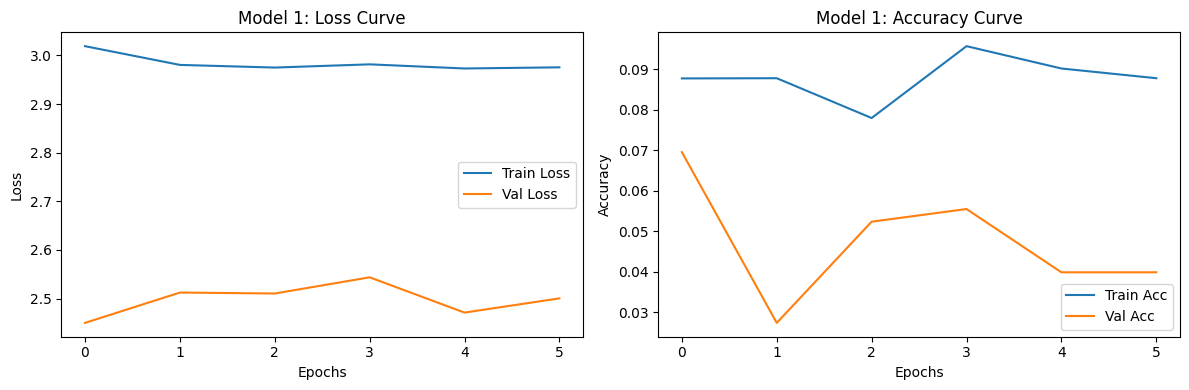

In [15]:
#  Plot training history for Model 1
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Model 1: Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.title('Model 1: Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()